In [3]:
# !pip install -U scikit-learn

# **Pendahuluan**

## **Import Library**

In [4]:
import pandas as pd
import os, re
import warnings 

from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from sklearn.metrics import matthews_corrcoef
import numpy as np

warnings.filterwarnings('ignore')

## **Data Preparation**

In [5]:
train = pd.read_csv('/kaggle/input/gammax/train.csv').rename({'is_referenced': 'label'}, axis=1)
test = pd.read_csv('/kaggle/input/gammax/test.csv')
feature = pd.read_csv('/kaggle/input/gammax/papers_metadata.csv')

In [6]:
feature.fillna('None', inplace=True)

setelah kita periksa ternyata hanya , feature yang berbasis object / string yang hilang. Oleh karena itu , kita mengisi misisng value dengan `None`

In [7]:
def change_to_str(data):
    columns_to_convert = ['doi', 'title', 'authors', 'concepts']
    
    for column in columns_to_convert:
        data[column] = data[column].astype(str)
    
    return data

feature = change_to_str(feature)
feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4354 entries, 0 to 4353
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   paper_id          4354 non-null   object
 1   doi               4354 non-null   object
 2   title             4354 non-null   object
 3   publication_year  4354 non-null   int64 
 4   publication_date  4354 non-null   object
 5   cited_by_count    4354 non-null   int64 
 6   type              4354 non-null   object
 7   authors           4354 non-null   object
 8   concepts          4354 non-null   object
dtypes: int64(2), object(7)
memory usage: 306.3+ KB


# **Main Method**

<iframe src="https://drive.google.com/file/d/1qHDvgQYFT2tkHvTBaKHtR7jxfRCEQO4-/preview" width="640" height="200"></iframe>


## **1. Documents/Paper Representation**

In [8]:
from gensim.models.callbacks import CallbackAny2Vec
import logging

class EpochLogger(CallbackAny2Vec):
    '''Callback untuk ngeprint progress setiap epoch'''
    def __init__(self):
        self.epoch = 0

    def on_epoch_begin(self, model):
        print(f'Starting epoch {self.epoch}')

    def on_epoch_end(self, model):
        print(f'Finished epoch {self.epoch}')
        self.epoch += 1

In [ ]:
import os

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models.fasttext import FastText
import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import pickle

data_dir = "/kaggle/input/gammax/Paper Database/Paper Database"

paper_texts = {}
for fname in os.listdir(data_dir):
    if fname.endswith(".txt"):
        paper_id = fname.replace(".txt", "")
        with open(os.path.join(data_dir, fname), 'r', encoding='utf-8') as f:
            paper_texts[paper_id] = f.read().lower()  

import nltk
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords



stop_words = set(stopwords.words('english'))

def tokenize_and_remove_stopwords(text):
    tokens = simple_preprocess(text)
    
    return [word for word in tokens if word not in stop_words]

tagged_docs = [
    TaggedDocument(words=tokenize_and_remove_stopwords(text), tags=[pid])
    for pid, text in paper_texts.items()
]


modeldoc = Doc2Vec(vector_size=90, window=17, min_count=2, workers=8, epochs=25)
modeldoc.build_vocab(tagged_docs)
modeldoc.train(tagged_docs, total_examples=modeldoc.corpus_count, epochs=modeldoc.epochs, callbacks=[EpochLogger()])


doc_vectors = {doc.tags[0]: modeldoc.dv[doc.tags[0]] for doc in tagged_docs}
vectors_df = pd.DataFrame.from_dict(doc_vectors, orient='index')
feature = feature.join(vectors_df, on='paper_id', how='left')

print("Model Doc2Vec training selesai dan vektor telah disimpan di DataFrame!")

#Optional
# modeldoc.save("DOC2VWD20E20.model")
# with open ("DOC2VWD20E20.model", "rb") as f:
#     modeldoc = pickle.load(f)

**Perbandingan Doc2Vec dan BERT/Transformer-Based Models**

Pada bagian ini, kita akan membandingkan **Doc2Vec** dengan model berbasis **BERT/Transformer** berdasarkan beberapa kelebihan yang dimiliki oleh Doc2Vec, serta bagaimana performa dan kelebihannya bila dibandingkan dengan BERT/Transformer.

**1. Kelebihan Doc2Vec**

- **Sangat Tidak Cost Sensitive**: Doc2Vec tidak memerlukan sumber daya komputasi yang besar dan relatif lebih murah dibandingkan model berbasis transformer seperti BERT.
- **Tidak Memerlukan GPU**: Doc2Vec dapat dilatih dan dijalankan di CPU, membuatnya lebih mudah diakses dan diimplementasikan tanpa membutuhkan perangkat keras yang kuat.
- **Cukup Cepat dan Representatif**: Dengan struktur yang lebih sederhana, Doc2Vec dapat menghasilkan representasi yang cepat dan cukup baik untuk banyak tugas pemrosesan bahasa alami.
- **Tidak Terbatasi oleh Max Length**: Doc2Vec tidak memiliki batas panjang input seperti yang terdapat pada model berbasis Transformer, sehingga lebih fleksibel dalam menangani dokumen dengan panjang yang bervariasi.
- **Memperhatikan Seluruh Isi Dokumen**: Doc2Vec membuat representasi vektor dari seluruh dokumen, memberikan gambaran umum dari teks tanpa kehilangan informasi konteks.

**2. Kelebihan BERT/Transformer-Based Models**

- **Lebih Akurat dalam Pemahaman Konteks**: BERT dapat memproses konteks kata secara bidirectional, memberikan pemahaman yang lebih baik terhadap teks dibandingkan Doc2Vec yang hanya mempertimbangkan urutan kata secara sekuensial.
- **Menggunakan Pretrained Models**: BERT menawarkan model yang sudah dilatih dengan dataset besar, memungkinkan untuk aplikasi cepat dalam berbagai tugas NLP tanpa perlu pelatihan dari awal.
- **Pemrosesan Teks yang Lebih Kompleks**: Transformer-based models dapat menangani teks yang lebih kompleks, seperti idiom, kalimat ambiguitas, dan konteks yang lebih dalam.
- **Batasan Panjang Input**: Salah satu keterbatasan utama BERT dan model berbasis Transformer adalah **batas panjang input** yang terbatas, biasanya sekitar 512 token (pada BERT standar). Pada kasus yang melibatkan dokumen yang token-nya bisa lebih dari 4000, ini menjadi masalah besar, karena BERT dan model standar lainnya tidak dapat menangani input lebih panjang tanpa pemrosesan tambahan. Meskipun model seperti **BigBird** dan **Longformer** telah dikembangkan untuk mengatasi batas panjang ini dengan mekanisme sparse attention, mereka tetap memiliki batasan yang lebih kecil dibandingkan **Doc2Vec**, yang tidak terbatas oleh panjang dokumen.

**3. Perbandingan Antara Doc2Vec dan BERT/Transformer-Based Models**

| **Kriteria**                      | **Doc2Vec**                                | **BERT/Transformer-Based**                       |
|------------------------------------|--------------------------------------------|-------------------------------------------------|
| **Kebutuhan Sumber Daya**          | Tidak cost-sensitive, dapat berjalan di CPU ✅ | Memerlukan GPU dan sumber daya yang lebih besar  |
| **Kecepatan Pelatihan**            | Cepat, lebih ringan dalam pelatihan ✅        | Relatif lebih lambat karena model yang lebih besar |
| **Kebutuhan GPU**                  | Tidak memerlukan GPU  ✅                      | Memerlukan GPU untuk pelatihan dan inferensi    |
| **Akurasi dalam Pemahaman Konteks**| Cukup baik, berdasarkan urutan kata       | Sangat akurat dengan konteks bidirectional  ✅    |
| **Fleksibilitas Panjang Dokumen**  | Tidak terbatas oleh panjang teks ✅          | Tergantung pada panjang input yang dapat diproses (biasanya ada batasan, seperti 512 token) |
| **Pretraining**                    | Tidak menggunakan model pretrained ✅        | Menggunakan model pretrained dengan dataset besar |
| **Representasi Dokumen**           | Mewakili seluruh dokumen dalam satu vektor ✅ | Memiliki representasi yang lebih rinci untuk setiap kata dalam konteks |
| **Penggunaan Sumber Daya**         | Lebih efisien dalam hal memori dan komputasi ✅ | Membutuhkan memori yang besar dan daya komputasi tinggi |
| **Cocok untuk Dokumen Panjang**    | Sangat cocok, karena tidak terbatas oleh panjang token ✅| Terbatas dengan panjang teks (misalnya 512 token untuk BERT standar), meskipun BigBird/Longformer memiliki batas yang lebih tinggi namun masih terbatas dibandingkan Doc2Vec |

**4. Kesimpulan**

- **`Doc2Vec`** adalah pilihan yang sangat baik jika  membutuhkan model yang cepat, tidak memerlukan sumber daya besar, dan dapat menangani dokumen panjang dengan fleksibel. Oleh karena itu , kita menggunakan Doc2Vec
- **BERT/Transformer-Based** models lebih cocok jika membutuhkan pemahaman yang lebih mendalam terhadap konteks dan memiliki sumber daya komputasi yang cukup besar. Namun, model-model ini memiliki keterbatasan terkait panjang input, yang menjadi masalah jika dokumen sangat panjang (lebih dari 4000 token). Walaupun model seperti **BigBird** dan **Longformer** menawarkan solusi dengan kapasitas panjang lebih besar, mereka masih tidak bisa mengalahkan fleksibilitas Doc2Vec dalam menangani dokumen yang sangat panjang tanpa batasan yang ketat.


## **2. Metadata Representation (`Title`, `Concepts`)**

### **A.) Title Representation (Fast Text)**

In [ ]:
from gensim.models.fasttext import FastText
from gensim.models.callbacks import CallbackAny2Vec

tokenized_titles = [title.lower().split() for title in feature['title']]

class EpochLogger(CallbackAny2Vec):
    def __init__(self, total_epochs):
        self.epoch = 0
        self.total_epochs = total_epochs

    def on_epoch_begin(self, model):
        print(f"[TITLE] Epoch {self.epoch + 1}/{self.total_epochs} start", end='\r')

    def on_epoch_end(self, model):
        print(f"[TITLE] Epoch {self.epoch + 1}/{self.total_epochs} end")
        self.epoch += 1

total_epochs = 15
modeltitle_ft = FastText(vector_size=5, window=2, min_count=1, workers=8, epochs=total_epochs, seed=42)

modeltitle_ft.build_vocab(corpus_iterable=tokenized_titles)
modeltitle_ft.train(corpus_iterable=tokenized_titles, total_examples=len(tokenized_titles), epochs=modeltitle_ft.epochs, callbacks=[EpochLogger(total_epochs)])

#modeltitle_ft.save("modeltitle_ft.model") #Optional

title_vectors_ft = []
for title in tokenized_titles:
    word_vectors = [modeltitle_ft.wv[word] for word in title if word in modeltitle_ft.wv]
    if word_vectors:
        title_vectors_ft.append(sum(word_vectors) / len(word_vectors))
    else:
        title_vectors_ft.append([0] * 10)

title_df_ft = pd.DataFrame(title_vectors_ft, columns=[f'ft_title_{i}' for i in range(5)])

# Gabungkan ke feature
feature = pd.concat([feature.reset_index(drop=True), title_df_ft], axis=1)

[TITLE] Epoch 1/15 endrt
[TITLE] Epoch 2/15 endrt
[TITLE] Epoch 3/15 endrt
[TITLE] Epoch 4/15 endrt
[TITLE] Epoch 5/15 endrt
[TITLE] Epoch 6/15 endrt
[TITLE] Epoch 7/15 endrt
[TITLE] Epoch 8/15 endrt
[TITLE] Epoch 9/15 endrt
[TITLE] Epoch 10/15 endrt
[TITLE] Epoch 11/15 endrt
[TITLE] Epoch 12/15 endrt
[TITLE] Epoch 13/15 endrt
[TITLE] Epoch 14/15 endrt
[TITLE] Epoch 15/15 endrt


### **B.) Title Representation (BERT `(AllenAi-SPECTER)`)**

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from tqdm import tqdm

tokenizer = AutoTokenizer.from_pretrained("allenai/specter")
model = AutoModel.from_pretrained("allenai/specter")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

title_dfz = feature[['paper_id', 'title']].copy()

def get_specter_embedding(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  


tqdm.pandas(desc="Encoding titles with SPECTER")
title_dfz['title_vector'] = title_dfz['title'].progress_apply(get_specter_embedding)

vector_df = pd.DataFrame(title_dfz['title_vector'].to_list(), columns=[f'specter_title_{i}' for i in range(title_dfz['title_vector'][0].shape[0])])

title_dfz = pd.concat([title_dfz.drop(columns=['title_vector']), vector_df], axis=1)


2025-04-23 18:26:36.858051: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745432796.880661    1736 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745432796.887476    1736 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Encoding titles with SPECTER: 100%|██████████| 4354/4354 [00:32<00:00, 133.38it/s]


Dalam notebook ini, kita akan meng-extract representasi judul artikel menggunakan dua metode berbeda: **`FastText`** dan **`SPECTER`**. Keduanya dipilih karena biaya komputasi yang relatif rendah, namun masing-masing memiliki keunggulan yang dapat dioptimalkan tergantung pada kebutuhan aplikasi.

**1. Mengapa Menggunakan FastText dan SPECTER?**

- **`FastText`** dari Gensim adalah model yang **`ringan dan efisien`** dalam menghasilkan representasi kata. Ini sangat cocok untuk tugas-tugas yang membutuhkan penggunaan sumber daya komputasi yang rendah, seperti ketika bekerja dengan dataset yang besar atau terbatasnya sumber daya komputasi.
  
- **`SPECTER`** adalah model berbasis BERT yang telah dioptimalkan untuk **`teks akademik`**. Meskipun berbasis arsitektur transformer, SPECTER lebih efisien dibandingkan BERT asli karena sudah di-tune untuk tugas yang lebih spesifik, sehingga lebih hemat dalam penggunaan sumber daya komputasi tanpa mengorbankan kualitas representasi.

**2. Keunggulan Menggunakan FastText dan SPECTER**

**`FastText`**
- **Fleksibilitas**: FastText dapat menangani kata yang tidak ditemukan dalam kamus (out-of-vocabulary words) dengan membaginya menjadi sub-kata.
- **Ringan**: Dapat dijalankan dengan sumber daya komputasi yang terbatas, seperti di CPU biasa, tanpa membutuhkan GPU.
- **Tidak Terbatas pada Panjang Input**: FastText tidak terikat pada panjang input, sehingga sangat cocok untuk data teks yang bervariasi panjangnya.

**`SPECTER`**
- **Diperuntukkan untuk Teks Akademik**: SPECTER telah dioptimalkan untuk menangani teks akademik, sehingga menghasilkan representasi yang lebih relevan dan mendalam untuk judul-judul penelitian.
- **Efisiensi**: Meskipun menggunakan arsitektur berbasis transformer, SPECTER telah di-tune untuk tugas akademik, menjadikannya lebih efisien dibandingkan model transformer lainnya seperti BERT.
- **Representasi yang Lebih Kuat**: SPECTER memberikan representasi yang lebih dalam dan kaya untuk teks akademik, berfokus pada konteks dan makna dari judul artikel.

**3. Ekstraksi Representasi dengan FastText dan SPECTER**

Kedua model ini akan digunakan untuk mengekstrak representasi dari judul artikel di dataset kita. Keunggulan utamanya adalah biaya komputasi yang rendah serta kemampuannya untuk menghasilkan representasi yang cukup akurat untuk aplikasi teks berbasis judul artikel.

- **`FastText`**: Kita akan menggunakan FastText untuk mendapatkan representasi kata dari setiap judul dengan cara rata-rata vektor kata yang ada di dalam judul tersebut.
- **`SPECTER`**: Kita juga akan menggunakan SPECTER untuk menghasilkan representasi berbasis transformer yang lebih mendalam, dengan keuntungan menggunakan model pretrained yang sudah dioptimalkan.

Langkah-Langkah Ekstraksi:

**`FastText`**: 
   - Tokenisasi judul artikel.
   - Latih model FastText pada tokenized data.
   - Ekstrak representasi rata-rata untuk setiap judul berdasarkan vektor kata yang dihasilkan oleh FastText.

**`SPECTER`**:
   - Tokenisasi judul artikel.
   - Gunakan model pretrained SPECTER untuk mengonversi judul menjadi vektor representasi.
   - SPECTER akan memberikan representasi yang lebih kaya dengan menggunakan arsitektur berbasis BERT.


**4. Perbandingan Proses Ekstraksi**

| **Metode**      | **Sumber Daya yang Dibutuhkan**      | **Kelebihan**                                      |
|-----------------|-------------------------------------|---------------------------------------------------|
| **FastText**    | CPU atau GPU                       | Ringan, dapat digunakan di berbagai perangkat keras, tidak terbatas panjang input. |
| **SPECTER**     | Memerlukan GPU untuk inferensi     | Representasi lebih kuat untuk teks akademik, efisien meskipun berbasis transformer. |

**5. Kesimpulan**

Kedua model **FastText** dan **SPECTER** sangat cocok untuk ekstraksi representasi judul artikel dengan biaya komputasi rendah. Meskipun FastText lebih cepat dan tidak membutuhkan GPU, SPECTER memberikan representasi yang lebih mendalam dan cocok untuk teks akademik.

Kedua model ini bisa digunakan secara bersamaan, mengingat keduanya memiliki **biaya komputasi rendah**, namun memberikan hasil yang cukup baik dalam konteks representasi judul artikel.

### **C.) Concepts Representation (Fast Text)**

In [ ]:
from gensim.models.fasttext import FastText
import pandas as pd
from gensim.models.callbacks import CallbackAny2Vec

tokenized_concepts = [
    [c.strip().lower().replace(" ", "_") for c in concepts.split(";") if c.strip()]
    for concepts in feature['concepts']
]

class EpochLogger(CallbackAny2Vec):
    def __init__(self, total_epochs):
        self.epoch = 0
        self.total_epochs = total_epochs

    def on_epoch_begin(self, model):
        print(f"[CONCEPTS] Epoch {self.epoch + 1}/{self.total_epochs} start", end='\r')

    def on_epoch_end(self, model):
        print(f"[CONCEPTS] Epoch {self.epoch + 1}/{self.total_epochs} end")
        self.epoch += 1


total_epochs = 15
modelconcept_ft = FastText(vector_size=5, window=2, min_count=1, workers=8, epochs=total_epochs, seed=42)

modelconcept_ft.build_vocab(corpus_iterable=tokenized_concepts)
modelconcept_ft.train(corpus_iterable=tokenized_concepts, total_examples=len(tokenized_concepts), epochs=modelconcept_ft.epochs, callbacks=[EpochLogger(total_epochs)])

# modelconcept_ft.save("modelconcept_ft.model") #Optional

concept_vectors_ft = []
for concept_list in tokenized_concepts:
    word_vectors = [modelconcept_ft.wv[word] for word in concept_list if word in modelconcept_ft.wv]
    if word_vectors:
        concept_vectors_ft.append(sum(word_vectors) / len(word_vectors))
    else:
        concept_vectors_ft.append([0] * 20)

concept_df_ft = pd.DataFrame(concept_vectors_ft, columns=[f'ft_concept_{i}' for i in range(5)])
feature = pd.concat([feature.reset_index(drop=True), concept_df_ft], axis=1)

[CONCEPTS] Epoch 1/15 endrt
[CONCEPTS] Epoch 2/15 endrt
[CONCEPTS] Epoch 3/15 endrt
[CONCEPTS] Epoch 4/15 endrt
[CONCEPTS] Epoch 5/15 endrt
[CONCEPTS] Epoch 6/15 endrt
[CONCEPTS] Epoch 7/15 endrt
[CONCEPTS] Epoch 8/15 endrt
[CONCEPTS] Epoch 9/15 endrt
[CONCEPTS] Epoch 10/15 endrt
[CONCEPTS] Epoch 11/15 endrt
[CONCEPTS] Epoch 12/15 endrt
[CONCEPTS] Epoch 13/15 endrt
[CONCEPTS] Epoch 14/15 endrt
[CONCEPTS] Epoch 15/15 endrt


### **D.) Concepts Representation  (BERT `(AllenAi-SPECTER)`)**

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
from tqdm import tqdm


tokenizer = AutoTokenizer.from_pretrained("allenai/specter")
model = AutoModel.from_pretrained("allenai/specter")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

concept_dfz = feature[['paper_id', 'concepts']].copy()

def get_specter_embedding(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()  

tqdm.pandas(desc="Encoding cocncepts with SPECTER")
concept_dfz['concepts_vector'] = concept_dfz['concepts'].progress_apply(get_specter_embedding)

vector_df = pd.DataFrame(concept_dfz['concepts_vector'].to_list(), columns=[f'specter_concepts_title_{i}' for i in range(concept_dfz['concepts_vector'][0].shape[0])])

concept_dfz = pd.concat([concept_dfz.drop(columns=['concepts_vector']), vector_df], axis=1)


Dalam notebook ini, kita juga akan meng-extract representasi **konsep** menggunakan dua metode berbeda: **FastText** dan **SPECTER**. Keduanya dipilih karena biaya komputasi yang rendah, namun masing-masing memiliki keunggulan yang dapat dioptimalkan tergantung pada kebutuhan aplikasi.

**1. Mengapa Menggunakan FastText dan SPECTER?**

- **`FastText`** dari Gensim adalah model yang `ringan dan efisien` dalam menghasilkan representasi kata. Ini sangat cocok untuk tugas-tugas yang membutuhkan penggunaan sumber daya komputasi yang rendah, seperti ketika bekerja dengan dataset yang besar atau terbatasnya sumber daya komputasi.
  
- **`SPECTER`** adalah model berbasis BERT yang telah dioptimalkan untuk `teks akademik`. Meskipun berbasis arsitektur transformer, SPECTER lebih efisien dibandingkan BERT asli karena sudah di-tune untuk tugas yang lebih spesifik, sehingga lebih hemat dalam penggunaan sumber daya komputasi tanpa mengorbankan kualitas representasi.

**2. Keunggulan Menggunakan FastText dan SPECTER**

**`FastText`**
- **Fleksibilitas**: FastText dapat menangani kata yang tidak ditemukan dalam kamus (out-of-vocabulary words) dengan membaginya menjadi sub-kata.
- **Ringan**: Dapat dijalankan dengan sumber daya komputasi yang terbatas, seperti di CPU biasa, tanpa membutuhkan GPU.
- **Tidak Terbatas pada Panjang Input**: FastText tidak terikat pada panjang input, sehingga sangat cocok untuk data teks yang bervariasi panjangnya.

**`SPECTER`**
- **Diperuntukkan untuk Teks Akademik**: SPECTER telah dioptimalkan untuk menangani teks akademik, sehingga menghasilkan representasi yang lebih relevan dan mendalam untuk **konsep**-konsep dalam konteks penelitian.
- **Efisiensi**: Meskipun menggunakan arsitektur berbasis transformer, SPECTER telah di-tune untuk tugas akademik, menjadikannya lebih efisien dibandingkan model transformer lainnya seperti BERT.
- **Representasi yang Lebih Kuat**: SPECTER memberikan representasi yang lebih dalam dan kaya untuk **konsep** akademik, berfokus pada konteks dan makna dari **konsep**-konsep yang disarankan dalam metadata.

**3. Mengapa Menggunakan FastText dan SPECTER untuk **Konsep**?**

Dalam konteks ini, **konsep** yang dimaksud sering kali lebih ringkas dan terfokus pada poin-poin utama yang ditemukan dalam metadata, yang sudah diringkas dan tidak terlalu panjang. Oleh karena itu, baik **FastText** maupun **SPECTER** sangat cocok digunakan untuk mengekstrak representasi dari **konsep**-konsep tersebut. 

- **`FastText`**: Model ini sangat efisien untuk mengekstrak representasi dari **konsep** yang lebih pendek dan sering kali mencakup kata-kata yang tidak ada dalam kamus.
- **`SPECTER`**: Dengan optimisasi untuk teks akademik, SPECTER mampu memberikan representasi yang lebih kaya dan relevan untuk **konsep** yang terdapat dalam metadata yang terstruktur dan lebih ringkas.

**4. Ekstraksi Representasi dengan FastText dan SPECTER**

Kedua model ini akan digunakan untuk mengekstrak representasi dari **konsep** yang ada dalam dataset kita. Keunggulan utamanya adalah biaya komputasi yang rendah serta kemampuannya untuk menghasilkan representasi yang cukup akurat untuk aplikasi berbasis **konsep**-konsep metadata.

- **`FastText`**: Kita akan menggunakan FastText untuk mendapatkan representasi kata dari setiap **konsep** dengan cara rata-rata vektor kata yang ada di dalam **konsep** tersebut.
- **`SPECTER`**: Kita juga akan menggunakan SPECTER untuk menghasilkan representasi berbasis transformer yang lebih mendalam, dengan keuntungan menggunakan model pretrained yang sudah dioptimalkan.

Langkah-Langkah Ekstraksi:

**`FastText`**: 
   - Tokenisasi **konsep**.
   - Latih model FastText pada tokenized data.
   - Ekstrak representasi rata-rata untuk setiap **konsep** berdasarkan vektor kata yang dihasilkan oleh FastText.

**`SPECTER`**:
   - Tokenisasi **konsep**.
   - Gunakan model pretrained SPECTER untuk mengonversi **konsep** menjadi vektor representasi.
   - SPECTER akan memberikan representasi yang lebih kaya dengan menggunakan arsitektur berbasis BERT.

**5. Perbandingan Proses Ekstraksi**

| **Metode**      | **Sumber Daya yang Dibutuhkan**      | **Kelebihan**                                      |
|-----------------|-------------------------------------|---------------------------------------------------|
| **FastText**    | CPU atau GPU                       | Ringan, dapat digunakan di berbagai perangkat keras, tidak terbatas panjang input. |
| **SPECTER**     | Memerlukan GPU untuk inferensi     | Representasi lebih kuat untuk **konsep** akademik, efisien meskipun berbasis transformer. |

**6. Kesimpulan**

Kedua model **FastText** dan **SPECTER** sangat cocok untuk ekstraksi representasi **konsep** dengan biaya komputasi rendah. Meskipun FastText lebih cepat dan tidak membutuhkan GPU, SPECTER memberikan representasi yang lebih mendalam dan cocok untuk **konsep** akademik.

Kedua model ini bisa digunakan secara bersamaan, mengingat keduanya memiliki **biaya komputasi rendah**, namun memberikan hasil yang cukup baik dalam konteks representasi **konsep** metadata.


## **3. Metadata Representation (Non Text)**

### **A.) Date Feature Engineering**

In [ ]:
def to_date_time(data):
    data['publication_date'] = pd.to_datetime(data['publication_date'], errors='coerce')

    mask_na_date = data['publication_date'].isna()
    mask_valid_year = pd.notna(data['publication_year'])
    data.loc[mask_na_date & mask_valid_year, 'publication_date'] = pd.to_datetime(
        '01/01/' + data.loc[mask_na_date & mask_valid_year, 'publication_year'].astype(str),
        format='%d/%m/%Y',
        errors='coerce'
    )

    data['month'] = data['publication_date'].dt.month.fillna(0).astype(int)
    data['day'] = data['publication_date'].dt.day.fillna(0).astype(int)

    return data

feature = to_date_time(feature)

Selanjutnya , akan di ekstraksi waktu yaitu mengubah tanggal publikasi menjadi date time untuk menambah fitur yang representatif.

### **B.) Authors Feature Engineering**

In [ ]:
def get_primary_author(authors_series):
    primary_authors = authors_series.apply(lambda x: x.split(';')[0].strip() if isinstance(x, str) and ';' in x else (x.strip() if isinstance(x, str) else None))
    return primary_authors

def count_primary_author_occurrences(dataframe, authors_column='authors', new_column_name='primary_author_count'):
    primary_authors = get_primary_author(dataframe[authors_column])
    author_counts = primary_authors.value_counts().to_dict()
    dataframe[new_column_name] = primary_authors.map(author_counts).fillna(0).astype(int)
    return dataframe

feature['primary_author'] = get_primary_author(feature['authors'])
feature = count_primary_author_occurrences(feature, authors_column='authors', new_column_name='primary_author_count')

Pada bagian ini kita hanya mengekstraksi pemilik (Nama Author) , dari jurnal. Fitur ini diharpakan juga dapat memberikan representasi yang cukup baik untuk prediksi nantinya.

### **C.) Journal Name (DOI) Feature Engineering (Optional)**

In [ ]:
import pandas as pd
import re
from urllib.parse import urlparse
from tqdm import tqdm

def extract_journal_name(doi_url):
    """
    Mengekstrak nama website/tempat jurnal dari URL DOI.

    Args:
        doi_url (str): URL DOI.

    Returns:
        str or None: Nama website/tempat jurnal atau None jika tidak dapat diekstrak.
    """
    if isinstance(doi_url, str) and doi_url.startswith("https://doi.org/"):
        try:
            parsed_url = urlparse(doi_url)
            path_segments = parsed_url.path.split('/')
            if len(path_segments) > 2:
                potential_name = path_segments[2].split('.')[0]
                return potential_name
            else:
                match = re.search(r"doi\.org\/10\.\d+\/([a-zA-Z0-9-]+)", doi_url)
                if match:
                    return match.group(1).split('.')[0]
        except Exception:
            return None
    return None

def create_journal_name_column_with_tqdm(dataframe, doi_column='doi', new_column_name='journal_name'):
    """
    Membuat kolom baru di DataFrame yang berisi nama website/tempat jurnal dari kolom DOI, dengan menggunakan tqdm.

    Args:
        dataframe (pd.DataFrame): DataFrame yang berisi kolom DOI.
        doi_column (str): Nama kolom yang berisi URL DOI (default: 'doi').
        new_column_name (str): Nama kolom baru untuk menyimpan nama jurnal (default: 'journal_name').

    Returns:
        pd.DataFrame: DataFrame dengan kolom baru yang berisi nama jurnal.
    """
    journal_names = []
    for doi in tqdm(dataframe[doi_column], desc="Extracting Journal Names"):
        journal_names.append(extract_journal_name(doi))
    dataframe[new_column_name] = journal_names
    return dataframe

feature = create_journal_name_column_with_tqdm(feature)
feature['total_cited_by_count_per_site'] = feature.groupby(['journal_name', 'publication_year'])['cited_by_count'].transform('mean')

Extracting Journal Names: 100%|██████████| 4354/4354 [00:00<00:00, 171987.72it/s]



Pada notebook ini, kita menjelaskan fungsi untuk mengekstrak nama jurnal dari URL DOI dan implementasinya untuk menambah kolom baru pada DataFrame, yang kemudian digunakan untuk analisis lebih lanjut.

## **4. Data Preparation for Training (Feature Engineering for Paper and References)**

### **A.) Feature Extraction to Train Dataset (Merge Metadata Representation and Document Representation)**

In [ ]:
# Ambil hanya kolom numerik dari feature
numerical_features = feature.select_dtypes(include='number')
numerical_feature_names = numerical_features.columns.tolist()

# Tambah kolom 'paper_id' buat join
numerical_features['paper_id'] = feature['paper_id']

# Merge fitur dari 'paper'
train_merged = train.merge(numerical_features, left_on='paper', right_on='paper_id', how='left')
train_merged = train_merged.rename(columns={col: f'{col}_paper' for col in numerical_feature_names})

# Merge fitur dari 'referenced_paper'
train_merged = train_merged.merge(numerical_features, left_on='referenced_paper', right_on='paper_id', how='left')
train_merged = train_merged.rename(columns={col: f'{col}_ref' for col in numerical_feature_names})

# Drop kolom ID hasil merge yang gak dipakai
train_merged



,paper,referenced_paper,label,publication_year_paper,cited_by_count_paper,0_paper,1_paper,2_paper,3_paper,4_paper,...,ft_concept_0_ref,ft_concept_1_ref,ft_concept_2_ref,ft_concept_3_ref,ft_concept_4_ref,month_ref,day_ref,primary_author_count_ref,total_cited_by_count_per_site_ref,paper_id_y
0,p2128,p3728,0,2021,357,0.133807,2.425045,3.516026,2.628832,5.929857,...,2.152482,-0.243626,1.459940,2.166929,-2.127061,1,1,3,2492.000000,p3728
1,p0389,p3811,0,1995,981,-3.783838,-6.096706,-0.857891,5.968105,-5.302592,...,1.941954,-0.295563,1.304326,1.991976,-1.884434,6,1,3,1169.811321,p3811
2,p1298,p3760,0,2017,16255,0.971798,-0.765241,-4.719200,4.295119,-0.852547,...,1.622277,0.012452,1.674822,1.605003,-1.850415,12,17,1,182.000000,p3760
3,p0211,p1808,0,2017,18641,3.377248,-1.904573,-2.885740,2.813201,0.593965,...,1.216073,-0.081154,1.038677,1.160670,-1.270961,9,1,1,1479.000000,p1808
4,p0843,p2964,0,2022,799,-6.031777,-2.581627,2.441402,-0.522494,-2.939475,...,1.535607,0.205591,1.784222,1.353299,-1.898473,1,1,1,645.000000,p2964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410686,p3478,p2966,0,1996,1056,-0.365042,-9.563304,1.368957,-1.045948,5.600297,...,2.264230,-0.392865,1.465489,2.273584,-2.102016,3,5,1,767.000000,p2966
410687,p0719,p2382,1,2017,1438,9.921428,2.813704,4.166034,5.341912,0.405513,...,1.676756,0.686651,2.834742,1.086740,-2.547796,3,27,1,2730.000000,p2382
410688,p1805,p3209,0,2015,2088,6.445601,-1.094483,-2.229727,1.385319,6.413883,...,1.754729,-0.051348,1.553547,1.709094,-1.839340,1,1,1,806.272727,p3209
410689,p4213,p0457,0,2020,707,2.058993,0.765467,4.445077,1.538046,3.039839,...,1.855709,-0.208949,1.330966,1.797521,-1.804249,1,1,1,806.272727,p0457


### **B.) Publication Date Feature Engineering (Paper and Source)**

In [ ]:
# Set index biar lookup cepet
pub_date_dict = feature.set_index('paper_id')['publication_date'].to_dict()

# Mapping aman
train_merged['publish_date_ref'] = train_merged['referenced_paper'].map(pub_date_dict)
train_merged['publish_date_paper'] = train_merged['paper'].map(pub_date_dict)

# Convert ke datetime
train_merged['publish_date_ref'] = pd.to_datetime(train_merged['publish_date_ref'], errors='coerce')
train_merged['publish_date_paper'] = pd.to_datetime(train_merged['publish_date_paper'], errors='coerce')

# Hitung selisih
train_merged['diff_date'] = (train_merged['publish_date_ref'] - train_merged['publish_date_paper']).dt.days
train_merged['diff_month'] = train_merged['diff_date'] / 30
train_merged['diff_week'] = train_merged['diff_date'] / 7
train_merged['diff_exact_year'] = train_merged['diff_date'] / 365
train_merged['diff_date'] = train_merged['diff_date'].fillna(0).astype(int)

Pada bagian ini, kita melakukan rekayasa fitur terkait tanggal publikasi untuk **paper** dan **referenced paper**. Proses ini melibatkan langkah-langkah berikut:

1. **Set Index untuk Lookup Cepat**: Mengonversi kolom `paper_id` menjadi indeks untuk memungkinkan pencarian tanggal publikasi yang lebih cepat.
   
2. **Mapping Tanggal Publikasi**: Menggunakan `map()` untuk menambahkan tanggal publikasi dari `paper_id` ke dalam kolom `publish_date_ref` dan `publish_date_paper`.

3. **Konversi ke Format Tanggal**: Mengonversi nilai tanggal publikasi menjadi format datetime menggunakan `pd.to_datetime()`.

4. **Menghitung Selisih Tanggal**: Menentukan selisih antara tanggal publikasi referensi dan tanggal publikasi paper dalam satuan hari, bulan, minggu, dan tahun.

5. **Penanganan Nilai Kosong**: Mengisi nilai kosong pada `diff_date` dengan nilai 0 dan mengonversinya menjadi integer.

Langkah-langkah ini memberikan informasi waktu yang berguna untuk analisis lebih lanjut dan model pelatihan.

In [ ]:
rows_to_drop = train_merged[(train_merged['label'] == 1) & (train_merged['publication_year_paper'] < train_merged['publication_year_ref'])]
indices_to_drop = rows_to_drop.index
train_merged = train_merged.drop(indices_to_drop)

Bagian ini hanyalah asumsi awal kami dimana jika ada paper yang mengsitasi paper lain , maka haruslah tahun nya lebih baru dibanding tahun yang lama 

### **C.) Vector Feature Engineering (Paper and Reference)**

#### **1. Similarity Calculation**

In [ ]:
def get_doc_vector(pid):
    try:
        return modeldoc.dv[pid]
    except KeyError:
        return np.zeros(model.vector_size)

def get_title_vector(pid):
    try:
        return modeltitle_ft.wv[pid]
    except KeyError:
        return np.zeros(modeltitle_ft.vector_size)
    
def get_concept_vector(pid):
    try:
        return modelconcept_ft.wv[pid]
    except KeyError:
        return np.zeros(modelconcept_ft.vector_size)
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr

# Doc2Vec calculations
doc_cosine_sims = []
doc_euclidean_dists = []
doc_manhattan_dists = []
doc_pearson_corrs = []

for i, row in tqdm(train_merged.iterrows(), total=len(train_merged), desc="Calculating Doc2Vec Metrics"):
    vec1 = get_doc_vector(row['paper'])
    vec2 = get_doc_vector(row['referenced_paper'])
    
    # Cosine similarity
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    doc_cosine_sims.append(cosine_sim)
    
    # Euclidean distance
    euc_dist = euclidean(vec1, vec2)
    doc_euclidean_dists.append(euc_dist)
    
    # Manhattan distance
    man_dist = cityblock(vec1, vec2)
    doc_manhattan_dists.append(man_dist)
    
    # Pearson correlation
    # Handle case where vectors have zero variance
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        doc_pearson_corrs.append(pearson_corr)
    else:
        doc_pearson_corrs.append(0.0)  # Default value for constant vectors

train_merged['doc2vec_cosine_sim'] = doc_cosine_sims
train_merged['doc2vec_euclidean_dist'] = doc_euclidean_dists
train_merged['doc2vec_manhattan_dist'] = doc_manhattan_dists
train_merged['doc2vec_pearson_corr'] = doc_pearson_corrs

# Title FastText calculations
title_cosine_sims = []
title_euclidean_dists = []
title_manhattan_dists = []
title_pearson_corrs = []

for i, row in tqdm(train_merged.iterrows(), total=len(train_merged), desc="Calculating Title FastText Metrics"):
    vec1 = get_title_vector(row['paper'])
    vec2 = get_title_vector(row['referenced_paper'])
    
    # Cosine similarity
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    title_cosine_sims.append(cosine_sim)
    
    # Euclidean distance
    euc_dist = euclidean(vec1, vec2)
    title_euclidean_dists.append(euc_dist)
    
    # Manhattan distance
    man_dist = cityblock(vec1, vec2)
    title_manhattan_dists.append(man_dist)
    
    # Pearson correlation
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        title_pearson_corrs.append(pearson_corr)
    else:
        title_pearson_corrs.append(0.0)

train_merged['title_cosine_sim'] = title_cosine_sims
train_merged['title_euclidean_dist'] = title_euclidean_dists
train_merged['title_manhattan_dist'] = title_manhattan_dists
train_merged['title_pearson_corr'] = title_pearson_corrs

# Concept FastText calculations
concept_cosine_sims = []
concept_euclidean_dists = []
concept_manhattan_dists = []
concept_pearson_corrs = []

for i, row in tqdm(train_merged.iterrows(), total=len(train_merged), desc="Calculating Concept FastText Metrics"):
    vec1 = get_concept_vector(row['paper'])
    vec2 = get_concept_vector(row['referenced_paper'])
    
    # Cosine similarity
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    concept_cosine_sims.append(cosine_sim)
    
    # Euclidean distance
    euc_dist = euclidean(vec1, vec2)
    concept_euclidean_dists.append(euc_dist)
    
    # Manhattan distance
    man_dist = cityblock(vec1, vec2)
    concept_manhattan_dists.append(man_dist)
    
    # Pearson correlation
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        concept_pearson_corrs.append(pearson_corr)
    else:
        concept_pearson_corrs.append(0.0)

train_merged['concept_cosine_sim'] = concept_cosine_sims
train_merged['concept_euclidean_dist'] = concept_euclidean_dists
train_merged['concept_manhattan_dist'] = concept_manhattan_dists
train_merged['concept_pearson_corr'] = concept_pearson_corrs

Calculating Concept FastText Metrics: 100%|██████████| 410631/410631 [07:08<00:00, 958.03it/s] 


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm

# Build embedding dictionary
specter_embedding_dict = {
    row['paper_id']: row[[f'specter_title_{i}' for i in range(768)]].values.astype(np.float32)
    for _, row in title_dfz.iterrows()
}

cosine_sims = []
euclidean_dists = []
manhattan_dists = []
pearson_corrs = []

for _, row in tqdm(train_merged.iterrows(), total=len(train_merged), desc="SPECTER Metrics"):
    pid1 = row['paper']
    pid2 = row['referenced_paper']
    
    if pid1 in specter_embedding_dict and pid2 in specter_embedding_dict:
        vec1 = specter_embedding_dict[pid1]
        vec2 = specter_embedding_dict[pid2]

        cosine_sims.append(cosine_similarity([vec1], [vec2])[0][0])
        euclidean_dists.append(euclidean(vec1, vec2))
        manhattan_dists.append(cityblock(vec1, vec2))

        try:
            pearson_corrs.append(pearsonr(vec1, vec2)[0])
        except:
            pearson_corrs.append(0.0)
    else:
        cosine_sims.append(0.0)
        euclidean_dists.append(0.0)
        manhattan_dists.append(0.0)
        pearson_corrs.append(0.0)


SPECTER Metrics: 100%|██████████| 410631/410631 [06:23<00:00, 1070.62it/s]


In [ ]:
train_merged['specter_cosine_sim'] = cosine_sims
train_merged['specter_euclidean_dist'] = euclidean_dists
train_merged['specter_manhattan_dist'] = manhattan_dists
train_merged['specter_pearson_corr'] = pearson_corrs


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm

# Build embedding dictionary
specter_embedding_dict = {
    row['paper_id']: row[[f'specter_concepts_title_{i}' for i in range(768)]].values.astype(np.float32)
    for _, row in concept_dfz.iterrows()
}

cosine_sims = []
euclidean_dists = []
manhattan_dists = []
pearson_corrs = []

for _, row in tqdm(train_merged.iterrows(), total=len(train_merged), desc="SPECTER Metrics"):
    pid1 = row['paper']
    pid2 = row['referenced_paper']
    
    if pid1 in specter_embedding_dict and pid2 in specter_embedding_dict:
        vec1 = specter_embedding_dict[pid1]
        vec2 = specter_embedding_dict[pid2]

        cosine_sims.append(cosine_similarity([vec1], [vec2])[0][0])
        euclidean_dists.append(euclidean(vec1, vec2))
        manhattan_dists.append(cityblock(vec1, vec2))

        try:
            pearson_corrs.append(pearsonr(vec1, vec2)[0])
        except:
            pearson_corrs.append(0.0)
    else:
        cosine_sims.append(0.0)
        euclidean_dists.append(0.0)
        manhattan_dists.append(0.0)
        pearson_corrs.append(0.0)


SPECTER Metrics: 100%|██████████| 410631/410631 [06:22<00:00, 1072.56it/s]


In [ ]:
train_merged['specter_cosine_sim_concepts'] = cosine_sims
train_merged['specter_euclidean_concepts_dist'] = euclidean_dists
train_merged['specter_manhattan_concepts_dist'] = manhattan_dists
train_merged['specter_pearson_concepts_corr'] = pearson_corrs


Pada tahap ini, kita menggunakan beberapa metrik untuk mengukur kesamaan antara dua dokumen berdasarkan representasi vektor yang dihasilkan oleh model seperti **Doc2Vec** ,**FastText** dan **BERT (AllenAi)**. Berikut adalah penjelasan tentang beberapa metrik yang digunakan:

##### **A. Cosine Similarity**
Cosine similarity mengukur kesamaan dua vektor dengan menghitung sudut antara mereka dalam ruang vektor. Nilai cosine similarity berkisar antara -1 hingga 1, di mana:
- **1** berarti kedua vektor sangat mirip (sejajar),
- **0** berarti kedua vektor tidak ada kesamaan arah,
- **-1** berarti kedua vektor berlawanan arah.

Rumus cosine similarity adalah sebagai berikut:
$$
\text{cosine\_similarity} = \frac{A \cdot B}{\|A\| \|B\|}
$$
Di mana \( A \) dan \( B \) adalah dua vektor yang dibandingkan, dan \( \|A\| \) serta \( \|B\| \) adalah panjang (norma) dari masing-masing vektor.

##### **B. Euclidean Distance**
Euclidean distance adalah ukuran jarak lurus antara dua titik dalam ruang vektor. Semakin kecil jarak Euclidean, semakin mirip dua dokumen tersebut. Rumusnya mirip dengan menghitung jarak fisik antara dua titik di ruang 2D atau 3D:
$$
d = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$
Di sini, **x** dan **y** adalah dua vektor dokumen yang dibandingkan, dan **n** adalah jumlah dimensi (fitur) pada vektor. Metrik ini sangat sensitif terhadap skala dan magnitudo vektor.

##### **C. Manhattan Distance**
Manhattan distance (juga dikenal sebagai L1 distance) mengukur jarak antara dua vektor dengan menghitung jumlah nilai absolut perbedaan antara setiap dimensi vektor:
$$
d = \sum_{i=1}^{n} |x_i - y_i|
$$
Metrik ini mirip dengan Euclidean, namun lebih fokus pada perbedaan total sepanjang setiap dimensi tanpa memperhitungkan arah, yang dapat lebih berguna dalam konteks data dengan banyak variabel yang tidak sebanding.

##### **D. Pearson Correlation**
Pearson correlation mengukur hubungan linier antara dua vektor. Nilai Pearson correlation berkisar antara -1 hingga 1, di mana:
- **1** menunjukkan korelasi positif sempurna (kedua vektor bergerak bersama ke arah yang sama),
- **-1** menunjukkan korelasi negatif sempurna (kedua vektor bergerak berlawanan),
- **0** menunjukkan tidak ada korelasi linier.

Rumus Pearson correlation adalah sebagai berikut:
$$
r = \frac{\sum{(x_i - \bar{x})(y_i - \bar{y})}}{\sqrt{\sum{(x_i - \bar{x})^2} \sum{(y_i - \bar{y})^2}}}
$$
Di mana $ x_i $ dan $ y_i $ adalah nilai-nilai elemen dalam dua vektor, dan $ \bar{x} $ dan $ \bar{y} $ adalah rata-rata dari masing-masing vektor.

---

Dengan menggunakan berbagai metrik ini, kita dapat memperoleh gambaran lebih lengkap tentang bagaimana dua dokumen saling terkait, baik dari segi kesamaan kontekstual, jarak fisik dalam ruang vektor, maupun hubungan linier antar elemen-elemen dalam dokumen.

#### **2. Scalar Vector Calculation (Paper and Reference)**

In [ ]:
def calculate_scalar_vector_features(df, col1, col2, get_vector_func, prefix):
    mean_combineds = []
    std_diffs = []
    sq_diff_sums = []
    abs_diff_sums = []

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Calculating {prefix} Scalar Features"):
        vec1 = get_vector_func(row[col1])
        vec2 = get_vector_func(row[col2])

        mean_combined = np.mean(np.concatenate([vec1, vec2]))
        std_diff = np.std(vec1 - vec2)
        sq_diff_sum = np.sum((vec1 - vec2) ** 2)
        abs_diff_sum = np.sum(np.abs(vec1 - vec2))

        mean_combineds.append(mean_combined)
        std_diffs.append(std_diff)
        sq_diff_sums.append(sq_diff_sum)
        abs_diff_sums.append(abs_diff_sum)

    df[f'{prefix}_mean_combined'] = mean_combineds
    df[f'{prefix}_std_diff'] = std_diffs
    df[f'{prefix}_sq_diff_sum'] = sq_diff_sums
    df[f'{prefix}_abs_diff_sum'] = abs_diff_sums

calculate_scalar_vector_features(
    train_merged, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

calculate_scalar_vector_features(
    train_merged, 'paper', 'referenced_paper', get_title_vector, prefix='title'
)

calculate_scalar_vector_features(
    train_merged, 'paper', 'referenced_paper', get_concept_vector, prefix='concept'
)

Calculating concept Scalar Features: 100%|██████████| 410631/410631 [01:26<00:00, 4750.60it/s]


Selain menghitung kemiripan dan jarak antar vektor, kami juga menambahkan fitur **berbasis skalar** yang dihitung dari perbedaan antara dua vektor representasi (vektor dari dokumen yang mengutip dan yang dikutip).

Fitur-fitur yang dihitung adalah:

- **Rata-rata Gabungan Vektor** $$ \text{mean}([v_1, v_2]) $$
  Mengukur nilai rata-rata dari dua vektor yang digabung. Bisa mencerminkan "pusat" dari kedua representasi.

- **Standar Deviasi dari Selisih Vektor** $$ \text{std}(v_1 - v_2) $$
  Mengukur seberapa besar variasi dari perbedaan antara dua vektor.

- **Jumlah Kuadrat Selisih** $$ \sum (v_1 - v_2)^2 $$
  Mirip dengan Euclidean Distance, tapi tanpa akar kuadrat. Memberi indikasi seberapa besar "energi" perbedaan antar elemen vektor.

- **Jumlah Nilai Absolut Selisih** $$ \sum |v_1 - v_2| $$ 
  Seperti Manhattan Distance, menggambarkan total jarak langsung di tiap dimensi antara dua vektor.

Fitur-fitur ini kami hitung untuk:
- **Representasi Doc2Vec**
- **Representasi FastText Judul**
- **Representasi FastText Konsep**

> Namun **tidak** kami hitung untuk representasi vektor dari **AllenAI SPECTER BERT**, karena keterbatasan waktu saat proses rekayasa fitur (_feature engineering_).


#### **3. Angular Similarity Feature Extraction (Paper and Reference)**

In [ ]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon

def calculate_vector_divergence_features(df, col1, col2, get_vector_func, prefix):
    angles = []

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Calculating {prefix} Divergence Features"):
        vec1 = get_vector_func(row[col1])
        vec2 = get_vector_func(row[col2])
        
        # Angle (arccos of cosine similarity)
        cos_sim = cosine_similarity([vec1], [vec2])[0][0]
        angle = np.arccos(np.clip(cos_sim, -1.0, 1.0))  # Clip to avoid NaNs
        angles.append(angle)

    df[f'{prefix}_angle'] = angles

calculate_vector_divergence_features(
    train_merged, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

calculate_vector_divergence_features(
    train_merged, 'paper', 'referenced_paper', get_title_vector, prefix='title'
)
calculate_vector_divergence_features(
    train_merged, 'paper', 'referenced_paper', get_concept_vector, prefix='concept'
)

Calculating concept Divergence Features: 100%|██████████| 410631/410631 [04:20<00:00, 1575.75it/s]


Untuk menambahkan informasi tambahan mengenai perbedaan arah dari dua vektor representasi, kami menghitung **sudut antar vektor** berdasarkan **cosine similarity**.

**Fitur yang dihitung**:

- **Sudut antara dua vektor**  
  Dihitung menggunakan rumus:

  $$
  \theta = \cos^{-1}(\text{cosine similarity}(v_1, v_2))
  $$

  Nilai ini mencerminkan **perbedaan arah** antara dua vektor. Jika dua vektor mengarah ke arah yang sama, maka sudutnya kecil (mendekati 0). Sebaliknya, jika berlawanan arah, maka sudutnya besar (mendekati π).

Kenapa penting?
Sudut ini bisa jadi indikator apakah dua dokumen memiliki **arah semantik yang sama atau tidak**, meskipun secara magnitudo mungkin berbeda. Ini berguna saat vektor sudah dinormalisasi atau ketika kita ingin melihat "sejauh mana dua dokumen membicarakan hal yang sejenis".

**Fitur ini kami hitung untuk**:

- **Representasi Doc2Vec**
- **Representasi FastText Judul**
- **Representasi FastText Konsep**

> Sama seperti sebelumnya, fitur ini **tidak dihitung** untuk representasi **AllenAI SPECTER BERT** karena keterbatasan waktu pada tahap eksperimen.


#### **4. Directional Relevance (Paper and Reference)**

In [ ]:
from scipy.stats import spearmanr
import numpy as np

def calculate_advanced_vector_features(df, col1, col2, get_vector_func, prefix):
    projections = []
  

    for i, row in tqdm(df.iterrows(), total=len(df), desc=f"Calculating {prefix} NN-like Features"):
        vec1 = get_vector_func(row[col1])
        vec2 = get_vector_func(row[col2])
        
        projection = np.dot(vec1, vec2) / (np.linalg.norm(vec2) + 1e-8)
        projections.append(projection)

    df[f'{prefix}_projection'] = projections

calculate_advanced_vector_features(
    train_merged, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

Calculating doc2vec NN-like Features: 100%|██████████| 410631/410631 [00:30<00:00, 13407.41it/s]


Fitur ini digunakan untuk mengukur **seberapa besar vektor pertama memproyeksikan dirinya ke arah vektor kedua**. Dalam konteks teks atau dokumen, ini bisa menggambarkan seberapa besar satu dokumen "mengandung" arah semantik dari dokumen lainnya.

**Rumus Proyeksi**:

$$
\text{Proyeksi} = \frac{\vec{a} \cdot \vec{b}}{\|\vec{b}\|}
$$

- $ \vec{a} \cdot \vec{b} $ adalah dot product antara dua vektor.
- $ \|\vec{b}\| $ adalah panjang (norm) dari vektor kedua.

**Interpretasi Nilai**:
- Nilai **besar dan positif** → vektor $ \vec{a} $ searah dengan $ \vec{b} $.
- Nilai **kecil** → vektor $ \vec{a} $ kurang sejajar dengan $ \vec{b} $.
- Bisa berguna untuk melihat **sejauh mana satu dokumen mengikuti arah semantik** dari dokumen referensinya.



# **Model and Evaluate**

In [ ]:
X = train_merged.select_dtypes(include='number')
X = X.drop(columns=['label'])
y = train_merged['label'].values

In [ ]:
X['now_year_paper'] = 2025 - X['publication_year_paper']
X['now_year_ref'] = 2025 - X['publication_year_ref']

X['diff_age'] = X['now_year_paper'] - X['now_year_ref']
X['ratio_age'] = X['now_year_ref'] / (X['now_year_paper'] + 1e-5)  # Hindari div by zero


X['citation_diff'] = X['cited_by_count_paper'] - X['cited_by_count_ref']
X['citation_ratio'] = X['cited_by_count_ref'] / (X['cited_by_count_paper'] + 1e-5)

Sedikit menggeneralisasi ide sebelumnya dan menambahkan elemen terkait tahun atau tanggal publikasi. Mengingat bahwa fitur tahun atau tanggal sangat berpengaruh dalam pemilihan referensi di dunia nyata, hal ini penting untuk diperhatikan.

## **Optuna (Hyperparameter Tuning) → Optional**

In [ ]:
# from sklearn.model_selection import train_test_split
# from catboost import CatBoostClassifier
# from sklearn.metrics import matthews_corrcoef
# from imblearn.over_sampling import RandomOverSampler
# import numpy as np
# import optuna

# def objective(trial):
#     # Hyperparameter space
#     # iterations = trial.suggest_int('iterations', 2000, 3000, step=25)
#     # learning_rate = trial.suggest_float('learning_rate', 0.05, 0.3, log=True)
#     l2_leaf_reg = trial.suggest_int('l2_leaf_reg', 1, 10)
    
#     # Feature-selected matrix (optional)
#     X_selected = X

#     # Train-test split
#     X_train, X_val, y_train, y_val = train_test_split(X_selected, y, test_size=0.17, stratify=y, random_state=42)

#     # Oversampling
#     ros = RandomOverSampler(random_state=42)
#     X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
    
#     # Train CatBoost
#     model = CatBoostClassifier(
#         iterations=2850,
#         learning_rate=0.12860233569187382,
#         l2_leaf_reg=l2_leaf_reg,
#         verbose=0,
#         random_state=42,
#         grow_policy='Lossguide',
#         task_type='GPU'
#     )
    
#     model.fit(X_resampled, y_resampled)

#     # Predict probabilities on validation
#     y_pred_proba = model.predict_proba(X_val)[:, 1]

#     # Search best threshold by MCC
#     thresholds = np.linspace(0.01, 0.99, 100)
#     best_mcc = -1
#     best_threshold = 0.5

#     for threshold in thresholds:
#         y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
#         mcc = matthews_corrcoef(y_val, y_pred_thresholded)
#         if mcc > best_mcc:
#             best_mcc = mcc
#             best_threshold = threshold

#     # Store results
#     trial.set_user_attr("best_threshold", best_threshold)

#     return best_mcc

# # Run Optuna
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)

# # Print Best Results
# print("Number of finished trials:", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value (Best MCC):", trial.value)
# print("  Params:", trial.params)
# print("  Best Threshold:", trial.user_attrs["best_threshold"])


## **CatBoost Model → Best Model After Evaluating With Another Model (LightGBM , NN-Based, XGBoost, Random Forest)**

In [ ]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, ADASYN
from sklearn.metrics import matthews_corrcoef
import numpy as np
from imblearn.under_sampling import NeighbourhoodCleaningRule


X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.17, random_state=42, stratify=y
)

X_train, y_train = RandomOverSampler(random_state=42).fit_resample(X_train, y_train)

model2 = CatBoostClassifier(
    iterations=2850,
    learning_rate=0.12860233569187382,
    grow_policy='Lossguide',
    task_type='GPU',
    verbose=50,  
    random_state=42,
)

model2.fit(X_train, y_train)

y_pred_proba = model2.predict_proba(X_val)[:, 1]
thresholds = np.linspace(0.01, 0.99, 100)  

best_mcc = -1
best_threshold = 0.5

for threshold in thresholds:
    y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
    mcc = matthews_corrcoef(y_val, y_pred_thresholded)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

print(f'Best Threshold for MCC: {best_threshold:.4f}')
print(f'Best Matthews Correlation Coefficient (MCC) on Validation Set: {best_mcc:.4f}')

0:	learn: 0.5328133	total: 21.6ms	remaining: 1m 1s
50:	learn: 0.1008832	total: 963ms	remaining: 52.8s
100:	learn: 0.0650173	total: 1.92s	remaining: 52.3s
150:	learn: 0.0460914	total: 2.86s	remaining: 51.2s
200:	learn: 0.0339644	total: 3.76s	remaining: 49.5s
250:	learn: 0.0256395	total: 4.63s	remaining: 48s
300:	learn: 0.0196101	total: 5.51s	remaining: 46.7s
350:	learn: 0.0152281	total: 6.4s	remaining: 45.5s
400:	learn: 0.0120010	total: 7.3s	remaining: 44.6s
450:	learn: 0.0094215	total: 8.19s	remaining: 43.5s
500:	learn: 0.0074700	total: 9.06s	remaining: 42.5s
550:	learn: 0.0059632	total: 9.96s	remaining: 41.6s
600:	learn: 0.0047781	total: 10.9s	remaining: 40.6s
650:	learn: 0.0038121	total: 11.8s	remaining: 39.7s
700:	learn: 0.0030667	total: 12.7s	remaining: 38.9s
750:	learn: 0.0024940	total: 13.6s	remaining: 38.1s
800:	learn: 0.0020225	total: 14.5s	remaining: 37.2s
850:	learn: 0.0016508	total: 15.4s	remaining: 36.3s
900:	learn: 0.0013611	total: 16.4s	remaining: 35.4s
950:	learn: 0.0011

## **Stratified KFold Cross Validation → Imbalanced Case Validation (Optional)**

In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from catboost import CatBoostClassifier
# from sklearn.metrics import matthews_corrcoef
# import numpy as np
# from imblearn.over_sampling import RandomOverSampler

# X = pd.DataFrame(X)
# y = pd.Series(y)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# best_mccs = []
# best_thresholds = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
#     print(f"\n--- Fold {fold + 1} ---")

#     X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
#     y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

#     # Resampling
#     X_train, y_train = RandomOverSampler(random_state=42, sampling_strategy=1).fit_resample(X_train, y_train)

#     # Model
#     model = CatBoostClassifier(
#     iterations=2850,
#     learning_rate=0.12860233569187382,
#     grow_policy='Lossguide',
#     task_type='GPU',
#     verbose=1000,  
#     random_state=42,
#     )

#     model.fit(X_train, y_train)

#     # Predict probs
#     y_pred_proba = model.predict_proba(X_val)[:, 1]

#     # Threshold tuning for MCC
#     thresholds = np.linspace(0.01, 0.99, 100)
#     best_mcc = -1
#     best_threshold = 0.5

#     for threshold in thresholds:
#         y_pred_thresholded = (y_pred_proba >= threshold).astype(int)
#         mcc = matthews_corrcoef(y_val, y_pred_thresholded)
#         if mcc > best_mcc:
#             best_mcc = mcc
#             best_threshold = threshold

#     print(f'Best Threshold: {best_threshold:.4f}')
#     print(f'Best MCC: {best_mcc:.4f}')
    
#     best_mccs.append(best_mcc)
#     best_thresholds.append(best_threshold)

# print(f"\nAverage MCC across folds: {np.mean(best_mccs):.4f}")
# print(f"Average Best Threshold: {np.mean(best_thresholds):.4f}")


## **CatBoost Model Evaluate → Evaluate Best Feature,Model**

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_val, y_pred_thresholded))
print(classification_report(y_val, y_pred_thresholded))


[[69045    44]
 [  527   192]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     69089
           1       0.81      0.27      0.40       719

    accuracy                           0.99     69808
   macro avg       0.90      0.63      0.70     69808
weighted avg       0.99      0.99      0.99     69808



Top 10 Feature Importances (CatBoost):
                             Feature  Importance
248                    doc2vec_angle    7.974470
254                         diff_age    7.878691
219             doc2vec_pearson_corr    5.151271
216               doc2vec_cosine_sim    4.815026
212                        diff_date    4.624389
251               doc2vec_projection    3.887883
228               specter_cosine_sim    2.176472
255                        ratio_age    1.934756
107               cited_by_count_ref    1.767992
234  specter_manhattan_concepts_dist    0.670408
213                       diff_month    0.669177
232      specter_cosine_sim_concepts    0.612983
231             specter_pearson_corr    0.610638
229           specter_euclidean_dist    0.605133
131                           23_ref    0.574038
257                   citation_ratio    0.478423
230           specter_manhattan_dist    0.442790
18                          16_paper    0.425593
54                          52

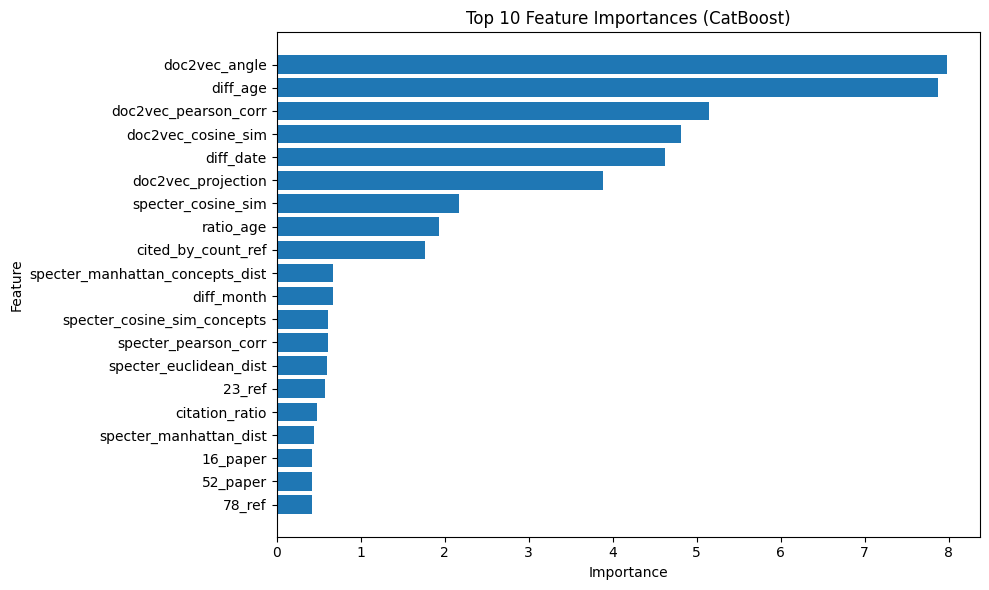

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

feature_importances = model2.get_feature_importance()
feature_names = X_train.columns  #

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("Top 10 Feature Importances (CatBoost):")
print(importance_df.head(40))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:20], importance_df['Importance'][:20])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

# **Predicting**

In [ ]:
testid = test['id']
test = test.drop(columns=['id'])

# Merge fitur dari 'paper'
test = test.merge(numerical_features, left_on='paper', right_on='paper_id', how='left')
test = test.rename(columns={col: f'{col}_paper' for col in numerical_feature_names})

# Merge fitur dari 'referenced_paper'
test = test.merge(numerical_features, left_on='referenced_paper', right_on='paper_id', how='left')
test = test.rename(columns={col: f'{col}_ref' for col in numerical_feature_names})

# Drop kolom ID hasil merge yang gak dipakai
test

,paper,referenced_paper,publication_year_paper,cited_by_count_paper,0_paper,1_paper,2_paper,3_paper,4_paper,5_paper,...,ft_concept_0_ref,ft_concept_1_ref,ft_concept_2_ref,ft_concept_3_ref,ft_concept_4_ref,month_ref,day_ref,primary_author_count_ref,total_cited_by_count_per_site_ref,paper_id_y
0,p0913,p3488,2010,401,-3.316654,-3.898887,-7.122129,8.658471,0.731293,2.668038,...,1.162307,0.272245,1.515264,0.909239,-1.496723,3,25,4,933.0,p3488
1,p2971,p4337,2020,74,-9.606321,-3.714645,-4.974587,-0.396276,-2.339198,6.489149,...,1.529858,0.013594,1.347746,1.384347,-1.729908,1,1,2,12629.0,p4337
2,p2237,p1610,2014,349,4.742624,-0.963916,5.322425,1.357907,5.437292,4.114721,...,1.142683,0.494231,2.076965,0.894240,-1.781902,8,17,24,3729.0,p1610
3,p2876,p3212,2020,21,0.051383,-1.425694,-2.715291,3.875911,-3.424484,4.246262,...,1.268431,0.539495,2.071610,0.944968,-1.857831,1,1,1,274.0,p3212
4,p2939,p1901,2016,592,1.997982,-3.701062,5.880289,2.135527,-1.644157,9.145401,...,1.778186,0.027219,1.682292,1.705304,-1.974369,1,1,3,51.0,p1901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336016,p0778,p2030,2006,348,4.171943,-4.560515,-0.608951,-1.819381,-4.340608,4.959444,...,1.344092,0.450436,2.046958,0.945849,-1.890467,2,16,1,176.0,p2030
336017,p3656,p2661,2021,5,-1.832230,-3.556752,-1.684169,-0.130252,-1.244321,3.060801,...,1.722812,0.267425,2.047756,1.266611,-2.208189,5,7,1,223.0,p2661
336018,p3088,p2517,2020,962,0.538783,-7.101543,3.646557,2.295797,1.732916,4.470127,...,2.001780,-0.073776,1.723726,1.916270,-2.156454,1,1,2,9.0,p2517
336019,p1789,p2958,2020,87,3.129496,2.335075,-3.887223,-0.960167,-0.905979,-4.509037,...,1.735124,-0.030038,1.726534,1.620107,-1.920763,1,1,1,1379.0,p2958


In [ ]:
# Mapping aman
test['publish_date_ref'] = test['referenced_paper'].map(pub_date_dict)
test['publish_date_paper'] = test['paper'].map(pub_date_dict)

# Convert ke datetime
test['publish_date_ref'] = pd.to_datetime(test['publish_date_ref'], errors='coerce')
test['publish_date_paper'] = pd.to_datetime(test['publish_date_paper'], errors='coerce')

# Hitung selisih
test['diff_date'] = (test['publish_date_ref'] - test['publish_date_paper']).dt.days
test['diff_month'] = test['diff_date'] / 30
test['diff_week'] = test['diff_date'] / 7
test['diff_exact_year'] = test['diff_date'] / 365

test['diff_date'] = test['diff_date'].fillna(0).astype(int)

In [ ]:
# Doc2Vec calculations
doc_cosine_sims = []
doc_euclidean_dists = []
doc_manhattan_dists = []
doc_pearson_corrs = []

for i, row in tqdm(test.iterrows(), total=len(test), desc="Calculating Doc2Vec Metrics"):
    vec1 = get_doc_vector(row['paper'])
    vec2 = get_doc_vector(row['referenced_paper'])
    
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    doc_cosine_sims.append(cosine_sim)
    
    euc_dist = euclidean(vec1, vec2)
    doc_euclidean_dists.append(euc_dist)
    
    man_dist = cityblock(vec1, vec2)
    doc_manhattan_dists.append(man_dist)
    
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        doc_pearson_corrs.append(pearson_corr)
    else:
        doc_pearson_corrs.append(0.0)

test['doc2vec_cosine_sim'] = doc_cosine_sims
test['doc2vec_euclidean_dist'] = doc_euclidean_dists
test['doc2vec_manhattan_dist'] = doc_manhattan_dists
test['doc2vec_pearson_corr'] = doc_pearson_corrs

# Title FastText calculations
title_cosine_sims = []
title_euclidean_dists = []
title_manhattan_dists = []
title_pearson_corrs = []

for i, row in tqdm(test.iterrows(), total=len(test), desc="Calculating Title FastText Metrics"):
    vec1 = get_title_vector(row['paper'])
    vec2 = get_title_vector(row['referenced_paper'])
    
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    title_cosine_sims.append(cosine_sim)
    
    euc_dist = euclidean(vec1, vec2)
    title_euclidean_dists.append(euc_dist)
    
    man_dist = cityblock(vec1, vec2)
    title_manhattan_dists.append(man_dist)
    
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        title_pearson_corrs.append(pearson_corr)
    else:
        title_pearson_corrs.append(0.0)

test['title_cosine_sim'] = title_cosine_sims
test['title_euclidean_dist'] = title_euclidean_dists
test['title_manhattan_dist'] = title_manhattan_dists
test['title_pearson_corr'] = title_pearson_corrs

# Concept FastText calculations
concept_cosine_sims = []
concept_euclidean_dists = []
concept_manhattan_dists = []
concept_pearson_corrs = []

for i, row in tqdm(test.iterrows(), total=len(test), desc="Calculating Concept FastText Metrics"):
    vec1 = get_concept_vector(row['paper'])
    vec2 = get_concept_vector(row['referenced_paper'])
    
    cosine_sim = cosine_similarity([vec1], [vec2])[0][0]
    concept_cosine_sims.append(cosine_sim)
    
    euc_dist = euclidean(vec1, vec2)
    concept_euclidean_dists.append(euc_dist)
    
    man_dist = cityblock(vec1, vec2)
    concept_manhattan_dists.append(man_dist)
    
    if np.var(vec1) > 0 and np.var(vec2) > 0:
        pearson_corr, _ = pearsonr(vec1, vec2)
        concept_pearson_corrs.append(pearson_corr)
    else:
        concept_pearson_corrs.append(0.0)

test['concept_cosine_sim'] = concept_cosine_sims
test['concept_euclidean_dist'] = concept_euclidean_dists
test['concept_manhattan_dist'] = concept_manhattan_dists
test['concept_pearson_corr'] = concept_pearson_corrs


Calculating Concept FastText Metrics: 100%|██████████| 336021/336021 [05:48<00:00, 965.20it/s] 


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm

# Build embedding dictionary
specter_embedding_dict = {
    row['paper_id']: row[[f'specter_title_{i}' for i in range(768)]].values.astype(np.float32)
    for _, row in title_dfz.iterrows()
}

cosine_sims = []
euclidean_dists = []
manhattan_dists = []
pearson_corrs = []

for _, row in tqdm(test.iterrows(), total=len(test), desc="SPECTER Metrics"):
    pid1 = row['paper']
    pid2 = row['referenced_paper']
    
    if pid1 in specter_embedding_dict and pid2 in specter_embedding_dict:
        vec1 = specter_embedding_dict[pid1]
        vec2 = specter_embedding_dict[pid2]

        cosine_sims.append(cosine_similarity([vec1], [vec2])[0][0])
        euclidean_dists.append(euclidean(vec1, vec2))
        manhattan_dists.append(cityblock(vec1, vec2))

        try:
            pearson_corrs.append(pearsonr(vec1, vec2)[0])
        except:
            pearson_corrs.append(0.0)
    else:
        cosine_sims.append(0.0)
        euclidean_dists.append(0.0)
        manhattan_dists.append(0.0)
        pearson_corrs.append(0.0)

test['specter_cosine_sim'] = cosine_sims
test['specter_euclidean_dist'] = euclidean_dists
test['specter_manhattan_dist'] = manhattan_dists
test['specter_pearson_corr'] = pearson_corrs


SPECTER Metrics: 100%|██████████| 336021/336021 [05:17<00:00, 1059.29it/s]


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import euclidean, cityblock
from scipy.stats import pearsonr
import numpy as np
from tqdm import tqdm

# Build embedding dictionary
specter_embedding_dict = {
    row['paper_id']: row[[f'specter_concepts_title_{i}' for i in range(768)]].values.astype(np.float32)
    for _, row in concept_dfz.iterrows()
}

cosine_sims = []
euclidean_dists = []
manhattan_dists = []
pearson_corrs = []

for _, row in tqdm(test.iterrows(), total=len(test), desc="SPECTER Metrics"):
    pid1 = row['paper']
    pid2 = row['referenced_paper']
    
    if pid1 in specter_embedding_dict and pid2 in specter_embedding_dict:
        vec1 = specter_embedding_dict[pid1]
        vec2 = specter_embedding_dict[pid2]

        cosine_sims.append(cosine_similarity([vec1], [vec2])[0][0])
        euclidean_dists.append(euclidean(vec1, vec2))
        manhattan_dists.append(cityblock(vec1, vec2))

        try:
            pearson_corrs.append(pearsonr(vec1, vec2)[0])
        except:
            pearson_corrs.append(0.0)
    else:
        cosine_sims.append(0.0)
        euclidean_dists.append(0.0)
        manhattan_dists.append(0.0)
        pearson_corrs.append(0.0)

test['specter_cosine_sim_concepts'] = cosine_sims
test['specter_euclidean_concepts_dist'] = euclidean_dists
test['specter_manhattan_concepts_dist'] = manhattan_dists
test['specter_pearson_concepts_corr'] = pearson_corrs


SPECTER Metrics: 100%|██████████| 336021/336021 [05:15<00:00, 1066.57it/s]


In [ ]:
calculate_scalar_vector_features(
    test, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

calculate_scalar_vector_features(
    test, 'paper', 'referenced_paper', get_title_vector, prefix='title'
)

calculate_scalar_vector_features(
    test, 'paper', 'referenced_paper', get_concept_vector, prefix='concept'
)

Calculating concept Scalar Features: 100%|██████████| 336021/336021 [01:09<00:00, 4868.22it/s]


In [ ]:
calculate_vector_divergence_features(
    test, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

calculate_vector_divergence_features(
    test, 'paper', 'referenced_paper', get_doc_vector, prefix='title'
)

calculate_vector_divergence_features(
    test, 'paper', 'referenced_paper', get_title_vector, prefix='concept'
)

Calculating concept Divergence Features: 100%|██████████| 336021/336021 [03:35<00:00, 1558.64it/s]


In [ ]:
calculate_advanced_vector_features(
    test, 'paper', 'referenced_paper', get_doc_vector, prefix='doc2vec'
)

Calculating doc2vec NN-like Features: 100%|██████████| 336021/336021 [00:25<00:00, 13289.10it/s]


In [ ]:
test['now_year_paper'] = 2025 - test['publication_year_paper']
test['now_year_ref'] = 2025 - test['publication_year_ref']

test['diff_age'] = test['now_year_paper'] - test['now_year_ref']
test['ratio_age'] = test['now_year_ref'] / (test['now_year_paper'] + 1e-5)

test['citation_diff'] = test['cited_by_count_paper'] - test['cited_by_count_ref']
test['citation_ratio'] = test['cited_by_count_ref'] / (test['cited_by_count_paper'] + 1e-5)


In [ ]:
test.fillna(0, inplace=True)

In [ ]:
colz = list(X.columns)
test2 = test[colz]

In [ ]:
pred = model2.predict_proba(test2.select_dtypes(include='number'))[:, 1]
pred = (pred >= 0.1189).astype(int)

In [ ]:
sub = pd.DataFrame({
    'id':testid,
    'is_referenced':pred
})

sub['is_referenced'].value_counts()

is_referenced
0    332492
1      3529
Name: count, dtype: int64

In [ ]:
model2.save_model("DV2058.cbm")

In [ ]:
sub.to_csv('submission-cb-Doc2V0585.csv', index=False)